# Comparative Analysis of BiLSTM and BERT for Emotion Recognition in Text

Group 30: Guanqiao Li, Sushma Ramesh, Ge Li

## Install necessary packages

In [1]:
# Install required packages (run once, safe to repeat)
!pip install -q datasets transformers scikit-learn tensorflow seaborn matplotlib

## Import libraries

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from transformers import BertForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from transformers import BertTokenizer
from datasets import load_dataset, Dataset
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout

## Load and Prepare the Dataset

In [3]:
# Load GoEmotions Dataset
dataset = load_dataset("go_emotions")

# Define the 10 target emotions we want to explore
target_emotions = ['admiration', 'amusement', 'anger', 'disappointment', 'disgust',
                   'fear', 'joy', 'love', 'sadness', 'surprise']

# Map label IDs to names
label_names = dataset['train'].features['labels'].feature.names
id2label = {i: label for i, label in enumerate(label_names)}

In [4]:
# Filter only samples with exactly one target label
def filter_emotions(example):
    return len(example['labels']) == 1 and id2label[example['labels'][0]] in target_emotions

def map_emotion(example):
    return {'emotion': id2label[example['labels'][0]]}

# Apply filtering and map the label to its string value
filtered_train = dataset['train'].filter(filter_emotions).map(map_emotion)
filtered_test = dataset['test'].filter(filter_emotions).map(map_emotion)

In [5]:
# Clean data by lowercasing, removing URLs, non-letters, and extra spaces
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

filtered_train = filtered_train.map(lambda x: {'text': clean_text(x['text'])})
filtered_test = filtered_test.map(lambda x: {'text': clean_text(x['text'])})

In [6]:
# Encode the labels to convert emotion labels to integers for training
label_encoder = LabelEncoder()
label_encoder.fit(target_emotions)

filtered_train = filtered_train.map(lambda x: {'label': label_encoder.transform([x['emotion']])[0]})
filtered_test = filtered_test.map(lambda x: {'label': label_encoder.transform([x['emotion']])[0]})

In [7]:
# Split the data into train, validation and test
split = filtered_train.train_test_split(test_size=0.2, seed=42) # Reserve 20% of training data for validation
train_data = split['train']
val_data = split['test']
test_data = filtered_test  

In [8]:
# Convert to Pandas 
df_train = train_data.to_pandas() # Easier for plotting
df_val = val_data.to_pandas()
df_test = test_data.to_pandas()

In [9]:
# Show a few samples
print("Sample training data:")
print(df_train.head())

Sample training data:
                                       text labels       id     emotion  label
0           lol eat your own farts trumpkin    [1]  ef057nf   amusement      1
1  this is the greatest thing ive ever read    [0]  efhca9f  admiration      0
2    i love the outfit that name is wearing    [0]  ee7hzw5  admiration      0
3         good viral marketing attempt name    [0]  eerkfop  admiration      0
4       i would love to see an name cosplay   [18]  effuuwv        love      7


In [10]:
# Show emotion distribution
print("\n Training label distribution:")
print(df_train['emotion'].value_counts())


 Training label distribution:
emotion
admiration        2140
amusement         1328
love              1136
anger              829
joy                677
sadness            668
surprise           584
disappointment     570
disgust            395
fear               345
Name: count, dtype: int64


In [12]:
# Total size of dataset we use for training
print(f"Dataset sizes:\nTrain: {len(df_train)}\nValidation: {len(df_val)}\nTest: {len(df_test)}")

Dataset sizes:
Train: 8672
Validation: 2169
Test: 1336


In [13]:
# Prepare datas for model training
train_texts = df_train['text'].tolist()
val_texts = df_val['text'].tolist()
test_texts = df_test['text'].tolist()

train_labels = df_train['label'].values
val_labels = df_val['label'].values
test_labels = df_test['label'].values

## Preprocess for BERT

In [14]:
# Load the tokenizer for the pre-trained BERT model
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased") # Lowercase all texts

# Tokenization
def tokenize(batch):
    return bert_tokenizer(
        batch['text'],                # Input text
        truncation=True,             # Truncate if too long
        padding='max_length',        # Pad to fixed length
        max_length=128               # Set max sequence length to 128 tokens
    )

# Convert Pandas DataFrames to Hugging Face Datasets
# Training set
train_dataset = Dataset.from_pandas(df_train[['text', 'label']])  # Only keep 'text' and 'label'
train_dataset = train_dataset.map(tokenize, batched=True)         # Apply tokenizer
train_dataset = train_dataset.remove_columns("text")              # Remove raw text

# Validation set
val_dataset = Dataset.from_pandas(df_val[['text', 'label']])
val_dataset = val_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.remove_columns("text")

# Test set
test_dataset = Dataset.from_pandas(df_test[['text', 'label']])
test_dataset = test_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.remove_columns("text")

C:\Users\lige2\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/8672 [00:00<?, ? examples/s]

Map:   0%|          | 0/2169 [00:00<?, ? examples/s]

Map:   0%|          | 0/1336 [00:00<?, ? examples/s]

## Train and Evaluate BERT

In [15]:
# Define BERT Model
num_classes = len(label_encoder.classes_)
model_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_classes)

# Evaluation metrics
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Training arguments
training_args = TrainingArguments(
    output_dir="./bert_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./logs",
    report_to="none"
)

# Trainer
trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=bert_tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=bert_tokenizer),
    compute_metrics=compute_metrics
)

# Train BERT
trainer.train()

C:\Users\lige2\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.190100,0.729842,0.786077,0.782470,0.786077,0.780484
2,0.583400,0.668568,0.807746,0.804465,0.807746,0.804189
3,0.415900,0.660422,0.813739,0.813840,0.813739,0.812177


TrainOutput(global_step=1626, training_loss=0.7298162537747204, metrics={'train_runtime': 8954.405, 'train_samples_per_second': 2.905, 'train_steps_per_second': 0.182, 'total_flos': 1711397222793216.0, 'train_loss': 0.7298162537747204, 'epoch': 3.0})

In [16]:
# Get predictions from the BERT model
bert_preds = trainer.predict(test_dataset)
y_true_bert = bert_preds.label_ids
y_pred_bert = bert_preds.predictions.argmax(-1)

# Print classification report
print("Classification Report (BERT):")
print(classification_report(y_true_bert, y_pred_bert, target_names=label_encoder.classes_))

Classification Report (BERT):
                precision    recall  f1-score   support

    admiration       0.87      0.87      0.87       348
     amusement       0.88      0.94      0.91       186
         anger       0.76      0.76      0.76       131
disappointment       0.54      0.56      0.55        88
       disgust       0.75      0.71      0.73        76
          fear       0.79      0.82      0.80        65
           joy       0.81      0.72      0.76        93
          love       0.86      0.92      0.89       160
       sadness       0.80      0.72      0.76       102
      surprise       0.71      0.69      0.70        87

      accuracy                           0.81      1336
     macro avg       0.78      0.77      0.77      1336
  weighted avg       0.81      0.81      0.81      1336



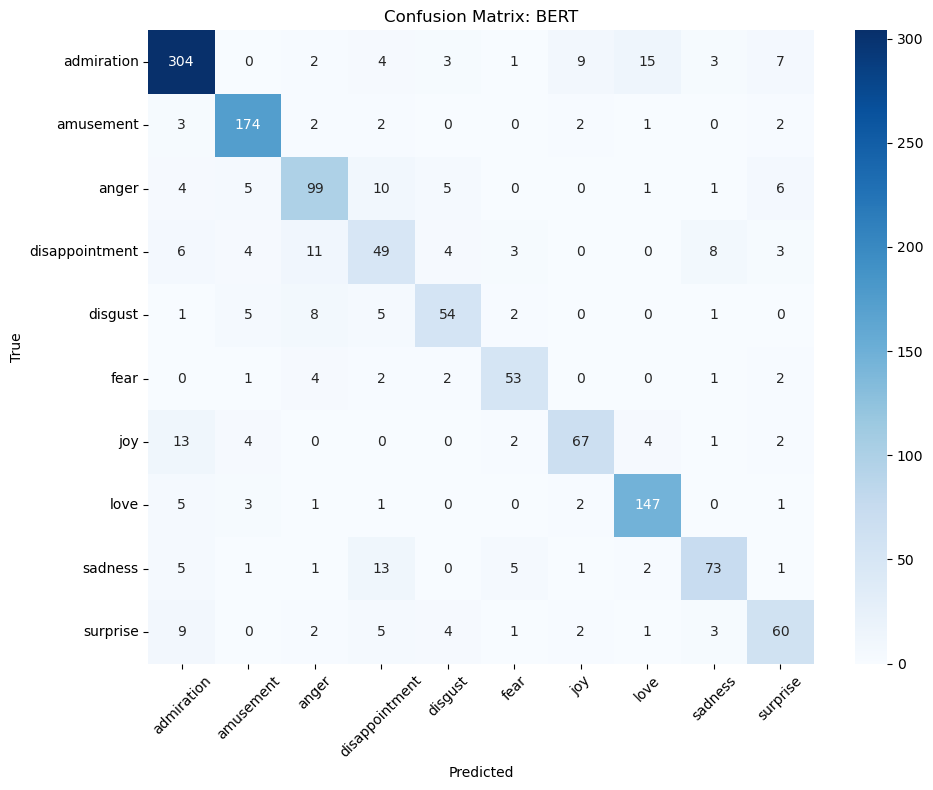

In [17]:
# Compute confusion matrix for BERT Model
cm_bert = confusion_matrix(y_true_bert, y_pred_bert)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix: BERT")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Preprocess for BiLSTM

In [18]:
# Define Tokenizer Parameters
vocab_size = 10000      # Limit to top 10,000 most frequent words in the dataset
max_length = 100        # Maximum sequence length for each input

# Initialize the Tokenizer
# OOV token ("<OOV>") handles words not in the top 10,000 vocabulary
tokenizer_bilstm = Tokenizer(num_words=vocab_size, oov_token="<OOV>")

# Fit the tokenizer on the training text to build the word index
tokenizer_bilstm.fit_on_texts(train_texts)

# Convert Texts to Sequences
train_seq = tokenizer_bilstm.texts_to_sequences(train_texts)
val_seq = tokenizer_bilstm.texts_to_sequences(val_texts)
test_seq = tokenizer_bilstm.texts_to_sequences(test_texts)

# Pad sequences
train_pad = pad_sequences(train_seq, maxlen=max_length, padding='post', truncating='post')
val_pad = pad_sequences(val_seq, maxlen=max_length, padding='post', truncating='post')
test_pad = pad_sequences(test_seq, maxlen=max_length, padding='post', truncating='post')

In [19]:
# Define BiLSTM model
model_bilstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_bilstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train BiLSTM
model_bilstm.fit(train_pad, train_labels, epochs=5, batch_size=32, validation_data=(val_pad, val_labels))

Epoch 1/5
271/271 [==============================] - 16s 44ms/step - loss: 2.0017 - accuracy: 0.3116 - val_loss: 1.6688 - val_accuracy: 0.4209
Epoch 2/5
271/271 [==============================] - 13s 47ms/step - loss: 1.4411 - accuracy: 0.5149 - val_loss: 1.3758 - val_accuracy: 0.5565
Epoch 3/5
271/271 [==============================] - 12s 44ms/step - loss: 1.1388 - accuracy: 0.6122 - val_loss: 1.3299 - val_accuracy: 0.6026
Epoch 4/5
271/271 [==============================] - 11s 40ms/step - loss: 0.9256 - accuracy: 0.6884 - val_loss: 1.3422 - val_accuracy: 0.6067
Epoch 5/5
271/271 [==============================] - 11s 42ms/step - loss: 0.7370 - accuracy: 0.7480 - val_loss: 1.5496 - val_accuracy: 0.6206


In [20]:
# Get predictions from BiLSTM Model
pred_probs = model_bilstm.predict(test_pad)
pred_labels = np.argmax(pred_probs, axis=1)

# Classification report for BiLSTM Model
print("\n Classification Report (BiLSTM):")
print(classification_report(test_labels, pred_labels, target_names=label_encoder.classes_))

42/42 [==============================] - 1s 14ms/step

 Classification Report (BiLSTM):
                precision    recall  f1-score   support

    admiration       0.71      0.84      0.77       348
     amusement       0.78      0.86      0.82       186
         anger       0.54      0.59      0.56       131
disappointment       0.18      0.05      0.07        88
       disgust       0.20      0.01      0.02        76
          fear       0.00      0.00      0.00        65
           joy       0.48      0.56      0.52        93
          love       0.87      0.84      0.85       160
       sadness       0.33      0.55      0.41       102
      surprise       0.36      0.46      0.40        87

      accuracy                           0.61      1336
     macro avg       0.44      0.48      0.44      1336
  weighted avg       0.55      0.61      0.57      1336



C:\Users\lige2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lige2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lige2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


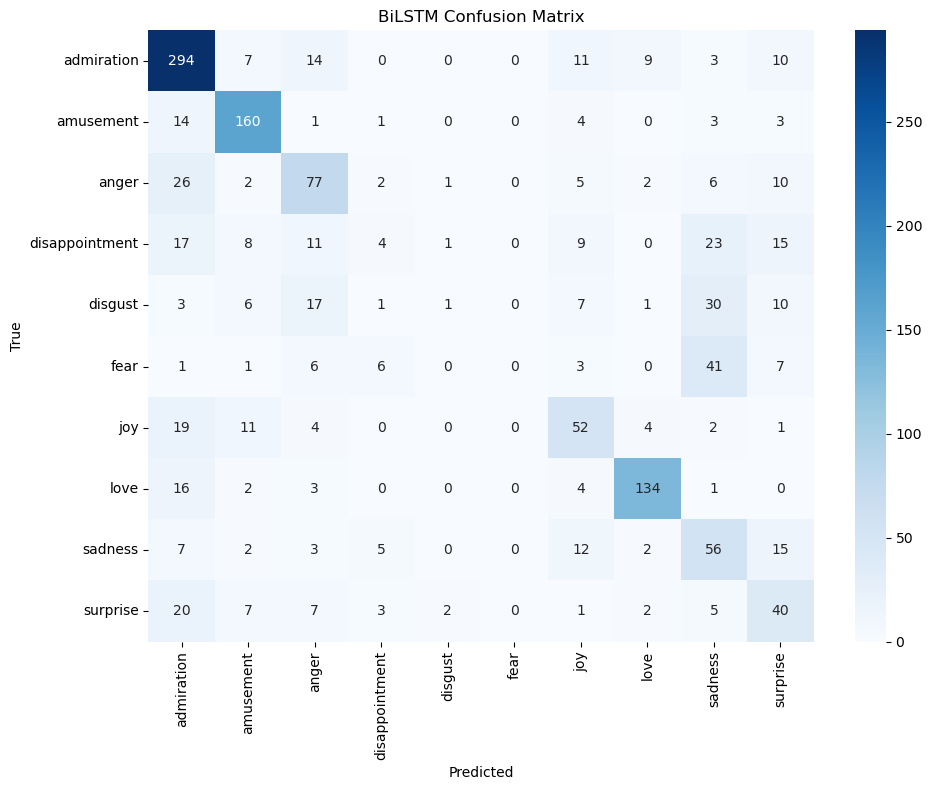

In [21]:
# Compute Confusion Matrix for BiLSTM Model
conf_matrix = confusion_matrix(test_labels, pred_labels)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('BiLSTM Confusion Matrix')
plt.tight_layout()
plt.show()

## Compare BERT vs. BiLSTM

In [25]:
# BERT Model Predictions
bert_preds = trainer.predict(test_dataset)
y_true_bert = bert_preds.label_ids                    
y_pred_bert = bert_preds.predictions.argmax(-1)

# BiLSTM Model Predictions
pred_probs_bilstm = model_bilstm.predict(test_pad)
y_pred_bilstm = np.argmax(pred_probs_bilstm, axis=1) # Predicted labels
y_true_bilstm = test_labels                          

42/42 [==============================] - 1s 15ms/step


In [26]:
# Generate Classification Reports
report_bert = classification_report(y_true_bert, y_pred_bert, target_names=label_encoder.classes_, output_dict=True)
report_bilstm = classification_report(y_true_bilstm, y_pred_bilstm, target_names=label_encoder.classes_, output_dict=True)

C:\Users\lige2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lige2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lige2\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


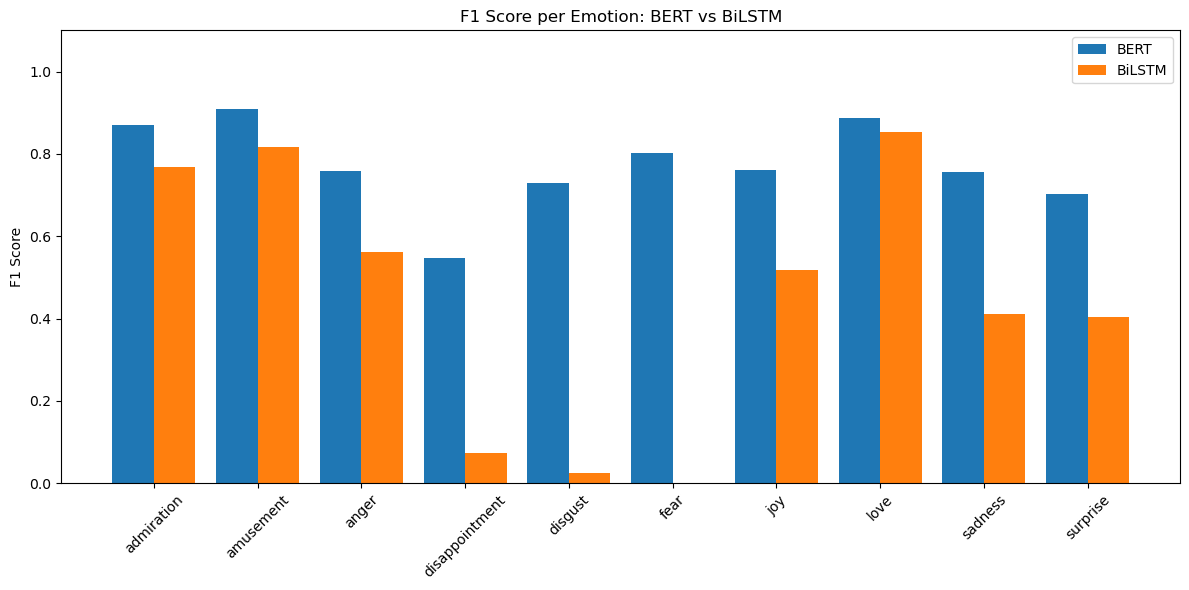

In [27]:
# Convert Reports to DataFrames for Plotting
df_bert = pd.DataFrame(report_bert).transpose()
df_bilstm = pd.DataFrame(report_bilstm).transpose()

# Extract f1-score per class (exclude avg rows)
f1_bert = df_bert.iloc[:len(label_encoder.classes_)]['f1-score']
f1_bilstm = df_bilstm.iloc[:len(label_encoder.classes_)]['f1-score']

# Plot
plt.figure(figsize=(12, 6))
x = range(len(label_encoder.classes_))
plt.bar(x, f1_bert, width=0.4, label='BERT', align='center')
plt.bar([i + 0.4 for i in x], f1_bilstm, width=0.4, label='BiLSTM', align='center')
plt.xticks([i + 0.2 for i in x], label_encoder.classes_, rotation=45)
plt.ylabel("F1 Score")
plt.title("F1 Score per Emotion: BERT vs BiLSTM")
plt.ylim(0, 1.1)
plt.legend()
plt.tight_layout()
plt.show()